In [68]:
# package load
import pandas as pd
import numpy as np
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import statsmodels.api as sm 


# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

# Result

### Analysis Result
- Plus Coef(+) : 전용면적, 긴급신고비율,1층, 여성생활인구비율, 요식업비율, 비요식업 폐업율, 지하철역, 살인범죄위험, 강간범죄위험
- Minus Coef(-) : 연식, 버스정류장수, 유흥업소수, 비요식업 개업율, 심야생활인구비율, 112신고건수, 강도범죄위험, 제2종근생시설, 약취범죄위험, 마약범죄위험, 폭력범죄위험, 판매용건물

### 분석결과 바탕으로 각 행정동별 (부동산외적)가격요인분포 탐색
> 행정동별 데이터셋 구축 및 회귀식값 도출

In [69]:
# 서울시 행정동
area_adm = gpd.GeoDataFrame.from_file('data/서울시위치정보/Z_SOP_BND_ADM_DONG_PG.shp', encoding='cp949')
area_adm = area_adm.iloc[:425,:] # 서울 행정동 435개
area_adm = area_adm[['ADM_DR_NM','geometry']]

## Dataset

### 전국 112신고접수 데이터
- 스마트치안빅데이터플랫폼 데이터셋

In [70]:
datals = os.listdir('data/전국112신고접수')
datals.sort()
datals = datals[-13:-1] # 2021년도 데이터

In [71]:
# columns
colnames = pd.read_csv('data/전국112신고접수/columns.csv', encoding='cp949')
colnames = colnames[' 컬럼영문명']
colnames.name = None

In [72]:
# data merge
df_112 = pd.DataFrame(columns=colnames)

for name in datals:
    df_i = pd.read_csv('data/전국112신고접수/'+ name, encoding='utf-8', header=None)
    df_i.columns = colnames
    df_112 = pd.concat([df_112, df_i], axis=0)

df_112 = df_112[df_112.columns.drop(['ACPT_YM'])]

In [73]:
# aggregate
df_112 = df_112.groupby('PLCST_NM', as_index=False).agg('sum')

In [74]:
# 서울 경찰서만 추리기
df_112 = df_112[df_112['PLCST_NM'].str.contains('서울')].reset_index(drop=True)
df_112 = df_112.set_index('PLCST_NM')
# df_112.head(3)

In [75]:
# 변수생성
df_112['총신고건수'] = df_112['RPRT_CASCNT_WHOL']
df_112['긴급신고비율'] = df_112['ACPT_EMERG_TYPE_EMERG'] / df_112['RPRT_CASCNT_WHOL']
df_112['야간신고비율'] = (df_112['OCRN_TIZN_22']+df_112['OCRN_TIZN_23']+df_112['OCRN_TIZN_00']+df_112['OCRN_TIZN_01']+df_112['OCRN_TIZN_02']) / df_112['RPRT_CASCNT_WHOL']

df_112 = df_112[['총신고건수','긴급신고비율','야간신고비율']]

### 생활안전지도 데이터
생활안전지도 api에서 추출한(`safemap.ipynb`) 데이터 불러오기
> 범죄 종류 : 살인,강도,강간,절도,폭력,방화,마약,약취유인,도박,전체

In [76]:
df_safety = gpd.GeoDataFrame.from_file('safemap.gpkg')
df_safety = df_safety[df_safety['polc_se'].isin(['03_파출소', '02_지구대'])]
df_safety.columns = ['polc_nm', 'plcstn_nm', 'polc_se', '살인', '강도', '강간', '절도',
       '폭력', '방화', '마약', '약취', '도박', '전체범죄', '시군구',
       'geometry']
df_safety.shape

(243, 15)

In [77]:
df_safety = df_safety.to_crs(epsg=5181) # epsg:5181

In [78]:
df_safety = df_safety.join(df_112, on='polc_nm') # 112 신고데이터 결합

### 각 행정동별 데이터셋 구축

In [79]:
df_safety['행정동'] = 0

for i in range(len(df_safety)):
    df_safety.at[i,'행정동'] = np.where(area_adm.geometry.contains(df_safety.geometry[i]))[0][0]

In [80]:
cols_crime = ['살인','강도','강간','절도','폭력','방화','마약','약취','도박']

In [81]:
df_safety = df_safety[['살인','강도','강간','절도','폭력','방화','마약','약취','도박','총신고건수','긴급신고비율','야간신고비율','행정동']].astype('float').groupby('행정동',as_index=True).agg('mean')
df_safety[cols_crime] = df_safety[cols_crime].astype('int')

In [82]:
df_safety.index = df_safety.index.astype('int')
df_safety # 223 rows

,살인,강도,강간,절도,폭력,방화,마약,약취,도박,총신고건수,긴급신고비율,야간신고비율
행정동,,,,,,,,,,,,
0,2,1,1,1,1,1,1,2,1,45240.0,0.005769,0.239655
1,1,1,1,1,1,1,1,5,1,45240.0,0.005769,0.239655
2,1,2,1,1,1,2,1,1,1,45240.0,0.005769,0.239655
3,1,1,1,1,1,1,1,5,1,45240.0,0.005769,0.239655
5,3,1,1,1,1,1,1,1,1,45240.0,0.005769,0.239655
...,...,...,...,...,...,...,...,...,...,...,...,...
411,4,1,1,1,1,2,1,1,1,96374.0,0.009349,0.294851
414,4,2,2,3,3,2,3,1,5,96374.0,0.009349,0.294851
417,4,1,3,3,3,4,2,1,4,96374.0,0.009349,0.294851


In [83]:
# Join
area_adm = area_adm.join(df_safety)

### 대중교통 데이터
: 행정동 내 속한 정류장 및 지하철역 수

In [84]:
# 버스정류장
df_bus = pd.read_csv('data/busstops.csv', encoding='cp949')
gdf_bus = gpd.GeoDataFrame(df_bus, geometry=gpd.points_from_xy(x=df_bus['X좌표'], y=df_bus['Y좌표'], crs='WGS84'))
gdf_bus = gdf_bus.to_crs(epsg=5181)

In [85]:
# 지하철역
df_sub = pd.read_csv('data/station_coordinate.csv', encoding='utf-8')
gdf_sub = gpd.GeoDataFrame(df_sub, geometry=gpd.points_from_xy(x=df_sub.lng, y=df_sub.lat, crs='WGS84'))
gdf_sub = gdf_sub.to_crs(epsg=5181)

In [86]:
# Count(3min)
area_adm['Bus'] = 0
area_adm['Subway'] = 0

for i in tqdm(range(len(area_adm))):
    # distance function
    bus_i = np.where(gdf_bus.geometry.within(area_adm.geometry[i]))[0] # 1D array
    sub_i = np.where(gdf_sub.geometry.within(area_adm.geometry[i]))[0] # 1D array
    area_adm.at[i,'Bus'] = len(bus_i)
    area_adm.at[i,'Subway'] = len(sub_i)

area_adm.head(3)

100%|██████████| 425/425 [00:11<00:00, 37.21it/s]


,ADM_DR_NM,geometry,살인,강도,강간,절도,폭력,방화,마약,약취,도박,총신고건수,긴급신고비율,야간신고비율,Bus,Subway
0,사직동,"POLYGON ((197702.069 453187.311, 197703.481 45...",2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,45240.0,0.005769,0.239655,28,2
1,삼청동,"POLYGON ((197980.839 455346.068, 197995.471 45...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,45240.0,0.005769,0.239655,15,0
2,부암동,"POLYGON ((196621.073 456395.880, 196628.373 45...",1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,45240.0,0.005769,0.239655,34,0


### 유흥업소

In [87]:
df_bars = gpd.GeoDataFrame.from_file('data/KLH_15_20211115_G_001/KLH_15_20211115_G_001.shp')
df_bars = df_bars[df_bars.PS_NM.str.startswith('서울')]
df_bars = df_bars[['PS_NM','PSS_NM','geometry']].reset_index(drop=True)
df_bars = df_bars.to_crs(epsg=5181)

In [88]:
# 각 행정동에 포함된 유흥업소 개수 count(10s)
area_adm['유흥업소'] = 0

for i in tqdm(range(len(area_adm))):
    # within function
    bar_i = np.where(df_bars.geometry.within(area_adm.geometry[i]))[0] # 1D array
    area_adm.at[i,'유흥업소'] = len(bar_i)

area_adm.head(3)

100%|██████████| 425/425 [00:02<00:00, 171.34it/s]


,ADM_DR_NM,geometry,살인,강도,강간,절도,폭력,방화,마약,약취,도박,총신고건수,긴급신고비율,야간신고비율,Bus,Subway,유흥업소
0,사직동,"POLYGON ((197702.069 453187.311, 197703.481 45...",2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,45240.0,0.005769,0.239655,28,2,5
1,삼청동,"POLYGON ((197980.839 455346.068, 197995.471 45...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,45240.0,0.005769,0.239655,15,0,0
2,부암동,"POLYGON ((196621.073 456395.880, 196628.373 45...",1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,45240.0,0.005769,0.239655,34,0,2


### 상권데이터

In [89]:
# 상권데이터 로드
commercial_area = gpd.GeoDataFrame.from_file('df_final.gpkg')
commercial_area = commercial_area.iloc[:,21:]

In [90]:
# 도로데이터에 결합할 상권데이터 변수 생성(float)
new_cols = commercial_area.columns[:-1]
area_adm[new_cols]=0.0

In [91]:
# 각 행정동별 포함하는 상권 리스트 > 평균치 활용
# 각 행정동 기준 어떤 상권과 Intersection인지 체크하여 상권데이터의 평균값 사용

for i in tqdm(range(len(area_adm))):
    area_ls = np.where(area_adm.geometry.intersects(commercial_area.geometry[i]))[0]
    if len(area_ls) == 0:
        pass
    elif len(area_ls) == 1:
        data_i = commercial_area.iloc[area_ls[0],:-1]
        area_adm.loc[i,new_cols] = data_i
    else:
        data_i = commercial_area.iloc[area_ls,:-1].mean()
        area_adm.loc[i,new_cols] = data_i


100%|██████████| 425/425 [00:01<00:00, 340.31it/s]


In [92]:
# Dataset complete
area_adm.to_csv('for_result.csv', index=False)

In [93]:
# Preprocessing
df = pd.read_csv('for_result.csv')
df['아파트_단지_수'] = df['아파트_단지_수'].fillna(0)

df.columns = ['행정동명', 'geometry', '살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취',
       '도박', '총신고건수', '긴급신고비율', '야간신고비율', 'Bus', 'Subway', '유흥업소', '총_생활인구',
       '남성_생활인구', '여성_생활인구', '연령대_10_생활인구', '연령대_20_생활인구',
       '연령대_30_생활인구', '연령대_40_생활인구', '연령대_50_생활인구', '연령대_60_이상_생활인구',
       '시간대_1_생활인구', '시간대_2_생활인구', '시간대_3_생활인구', '시간대_4_생활인구',
       '시간대_5_생활인구', '시간대_6_생활인구', '아파트_단지', '아파트_평균_시가', '개업_점포_비요식업',
       '개업_점포_요식업', '점포_비요식업', '점포_요식업', '폐업_점포_비요식업', '폐업_점포_요식업',
       '프랜차이즈_점포_비요식업', '프랜차이즈_점포_요식업', '매출액', '매출건수']  # type: ignore

df = df.drop(['geometry','아파트_평균_시가','매출건수'], axis=1)
df = df.dropna(axis=0) # 223

# data type
crimes = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박']
for n in crimes:
    df[n] = df[n].astype('int')

# 심야생활인구비율
df['생활인구_야간비율'] = df['시간대_6_생활인구'] / df['총_생활인구'] # 시간대 6(21-24시)
df['생활인구_심야비율'] = df['시간대_1_생활인구'] / df['총_생활인구'] # 시간대 1(00-06시)
df['생활인구_여성비율'] = df['여성_생활인구'] / (df['총_생활인구'])

# Drop nonusing population features
df = df.drop(['남성_생활인구', '여성_생활인구',
       '연령대_10_생활인구', '연령대_20_생활인구', '연령대_30_생활인구', '연령대_40_생활인구',
       '연령대_50_생활인구', '연령대_60_이상_생활인구', '시간대_1_생활인구', '시간대_2_생활인구',
       '시간대_3_생활인구', '시간대_4_생활인구', '시간대_5_생활인구', '시간대_6_생활인구'], axis=1)

# 요식업 및 점포관련 변수 생성
df['개업율_요식업'] = df['개업_점포_요식업'] / df['점포_요식업']
df['폐업율_요식업'] = df['폐업_점포_요식업'] / df['점포_요식업']
df['프랜차이즈비율_요식업'] = df['프랜차이즈_점포_요식업'] / df['점포_요식업']

df['개업율_비요식업'] = df['개업_점포_비요식업'] / df['점포_비요식업']
df['폐업율_비요식업'] = df['폐업_점포_비요식업'] / df['점포_비요식업']
df['프랜차이즈비율_비요식업'] = df['프랜차이즈_점포_비요식업'] / df['점포_비요식업']

df['요식업비율'] = df['점포_요식업'] / (df['점포_요식업'] + df['점포_비요식업'])

df = df.drop(df.columns[df.columns.str.contains('점포')].tolist(), axis=1)

In [94]:
# Ordered Categorical Variable
cols_crime = ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박']

t = pd.CategoricalDtype(categories=[1,2,3,4,5], ordered=True)
df[cols_crime] = df[cols_crime].astype(t)

df = df.reset_index(drop=True)

In [95]:
# Transformation
cols_tf = ['총신고건수', '긴급신고비율', '야간신고비율', '총_생활인구', '아파트_단지', '매출액', 'Bus', 'Subway', 
'유흥업소', '생활인구_야간비율', '생활인구_심야비율', '생활인구_여성비율', '개업율_요식업', 
'폐업율_요식업', '프랜차이즈비율_요식업', '개업율_비요식업', '폐업율_비요식업', '프랜차이즈비율_비요식업','요식업비율']

for col in cols_tf:
    df[col] = np.log1p(df[col])
    df[col] = (df[col] - df[col].mean()) / df[col].std()

## Prediction

In [96]:
# Regression Value(predicted)
df[cols_crime] = df[cols_crime].astype('float')

coefs = pd.read_csv('coefs.csv', index_col=0)
coefs = coefs.drop(['전용면적','연식','1층유무','용도_제2종근린생활','용도_판매'], axis=0) # 내적변수 제외

df['Prediction'] = 0.0

for i in range(len(coefs)):
    col_i = coefs.index[i]
    coef_i = coefs.at[col_i, 'coef']
    df['Prediction'] = df['Prediction'] + coef_i * df[col_i]

## Plot

In [97]:
# 서울시 행정동
from copy import deepcopy
area_adm = gpd.GeoDataFrame.from_file('data/서울시위치정보/Z_SOP_BND_ADM_DONG_PG.shp', encoding='cp949')
area_adm = area_adm.iloc[:425,:] # 서울 행정동 435개
area_adm = area_adm[['ADM_DR_NM','geometry']]
area_adm_untreated = deepcopy(area_adm) # 밑그림 위한 untreated df

In [98]:
# Join
df = df.set_index('행정동명')
area_adm = area_adm.join(df['Prediction'],on='ADM_DR_NM')

In [99]:
area_adm.dropna().sort_values(by=['Prediction'], ascending=False).head(3) # 예측값 높은 세개 행정동

,ADM_DR_NM,geometry,Prediction
374,수서동,"POLYGON ((209141.950 443707.377, 209152.831 44...",0.629148
46,한강로동,"POLYGON ((197640.806 448985.732, 197649.586 44...",0.580282
23,을지로동,"POLYGON ((200293.298 452231.984, 200310.878 45...",0.555143


In [100]:
# 기준금액 : 참고자료 참고

df_re = pd.read_csv('assets.csv')
df_re['기준금액'] = np.log(df_re['거래금액'] / df_re['전용면적']**0.034)

df_re = df_re[['도로명','기준금액']]
df_re = df_re.groupby(by='도로명', as_index=False).agg('mean') # 도로별 평균면적당금액

## Comparison with Actual Price

### Dataset

In [101]:
# import seoul roads
# 도로정보
seoul_road = gpd.GeoDataFrame.from_file('data/서울시위치정보/Z_KAIS_TL_SPRD_MANAGE_11000.shp', encoding='cp949')
seoul_road = seoul_road[['RN','geometry']]
seoul_road = seoul_road.loc[seoul_road.RN.isin(df_re.도로명.unique()),:]
seoul_road = seoul_road.dissolve(by='RN', as_index=False)

In [102]:
seoul_road['area_nm'] = [[] for _ in range(len(seoul_road))]
for i in tqdm(range(len(seoul_road))):
    area_i = np.where(area_adm.geometry.intersects(seoul_road.geometry[i]))[0]
    seoul_road.at[i,'area_nm'] = area_i

100%|██████████| 1503/1503 [00:04<00:00, 343.47it/s]


In [103]:
df_re = df_re.join(seoul_road.drop('geometry', axis=1).set_index('RN'), on='도로명')

In [104]:
prices = [[] for _ in range(len(area_adm))]

for i in tqdm(range(len(df_re))):
    area_ls = df_re.at[i,'area_nm']
    price_i = df_re.at[i,'기준금액']
    for j in area_ls:
        prices[j].append(price_i)

price = []
for i in range(len(prices)):
    if len(prices[i])>0:
        price.append(np.mean(prices[i]))
    else:
        price.append(None)

area_adm['Actual'] = price

100%|██████████| 1503/1503 [00:00<00:00, 134219.87it/s]


### Check Equally-distributed

In [105]:
area_adm['Prediction_normed'] = (area_adm['Prediction'] - area_adm['Prediction'].mean())/area_adm['Prediction'].std()
area_adm['Actual_normed'] = (area_adm['Actual'] - area_adm['Actual'].mean())/area_adm['Actual'].std()

In [106]:
area_adm = area_adm.dropna(axis=0) # Drop NA

In [107]:
arr = pd.DataFrame(pd.concat([area_adm['Prediction_normed'],area_adm['Actual_normed']], axis=0),columns=['Value']).reset_index(drop=True)
arr['Predicted'] = 0
arr.loc[:223,'Predicted'] = 1
arr.Predicted = np.where(arr.Predicted == 1, 'Predicted', 'Actual')
arr.Predicted.value_counts()

Predicted    224
Actual       224
Name: Predicted, dtype: int64

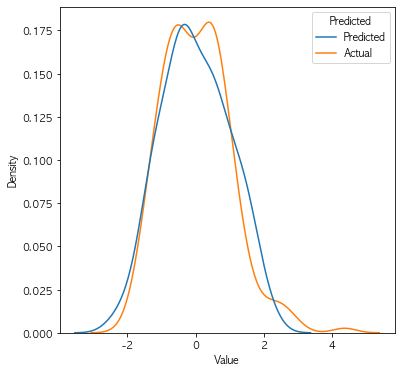

In [108]:
# KDE plot
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.kdeplot(data=arr,x='Value',hue='Predicted',ax=ax)
plt.show()

In [109]:
# Kolmogorov-Smirnov Test

from scipy.stats import kstest

kstest(area_adm['Prediction_normed'], area_adm['Actual_normed']) 
# identical ! (p>0.05 : null hyp i.e. equally-distributed)

KstestResult(statistic=0.05803571428571429, pvalue=0.8460991527008623)

#### except outlying (idx=43)

In [110]:
area_adm_new = area_adm.drop(index=40, axis=0) # 보광동
area_adm_new['Prediction_normed'] = (area_adm_new['Prediction'] - area_adm_new['Prediction'].mean())/area_adm_new['Prediction'].std()
area_adm_new['Actual_normed'] = (area_adm_new['Actual'] - area_adm_new['Actual'].mean())/area_adm_new['Actual'].std()

In [111]:
from scipy.stats import kstest

kstest(area_adm_new['Prediction_normed'], area_adm_new['Actual_normed']) 
# identical (p>0.05 : accept null hyp i.e. equally-distributed)

KstestResult(statistic=0.05829596412556054, pvalue=0.8441787400678193)

#### normalized

In [112]:
# Cmap scaling
combined_arr = np.array([area_adm_new['Prediction_normed'],area_adm_new['Actual_normed']])
_min, _max = np.amin(combined_arr), np.amax(combined_arr)

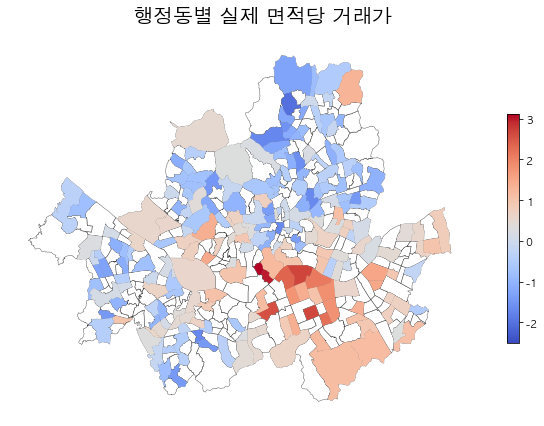

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

area_adm_untreated.geometry.plot(ax=ax, zorder=1, color='white', alpha=0.6, edgecolor='black', linewidth=0.5)
area_adm.plot(column='Actual_normed', ax=ax, legend=True, 
zorder=2, cmap='coolwarm', legend_kwds={'shrink': 0.6}, vmin=_min, vmax=_max)

plt.axis('off')
plt.suptitle('행정동별 실제 면적당 거래가',fontsize=20)
plt.tight_layout()
plt.savefig(f'plots/resultplot.png', facecolor='white')

In [114]:
area_adm.sort_values('Actual_normed')

,ADM_DR_NM,geometry,Prediction,Actual,Prediction_normed,Actual_normed
149,방학3동,"POLYGON ((202202.990 463621.331, 202220.930 46...",-0.477671,9.243137,-1.291619,-2.037819
142,인수동,"POLYGON ((200962.019 460593.370, 200967.749 46...",-0.279816,9.398422,-0.641319,-1.711968
326,서원동,"POLYGON ((194181.089 442820.048, 194181.040 44...",-0.245409,9.406255,-0.528229,-1.695530
27,신당동,"POLYGON ((201566.793 452246.873, 201567.849 45...",-0.001038,9.416557,0.274956,-1.673914
83,청량리동,"POLYGON ((203798.262 455266.850, 203859.743 45...",-0.446708,9.418242,-1.189852,-1.670379
...,...,...,...,...,...,...
349,반포4동,"POLYGON ((200886.439 445115.746, 200918.421 44...",0.305004,11.441495,1.280844,2.575230
366,역삼2동,"POLYGON ((204133.836 443861.568, 204131.227 44...",-0.158357,11.478607,-0.242113,2.653106
376,압구정동,"POLYGON ((202059.684 448477.464, 202069.696 44...",0.234706,11.489365,1.049790,2.675681
43,보광동,"POLYGON ((199832.465 448125.524, 199842.488 44...",-0.002896,11.638378,0.268850,2.988371


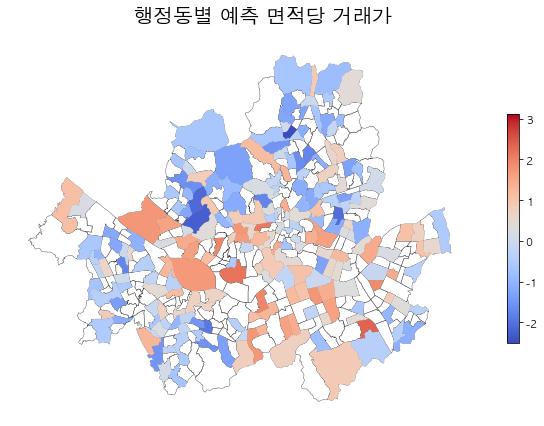

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

area_adm_untreated.geometry.plot(ax=ax, zorder=1, color='white', alpha=0.6, edgecolor='black', linewidth=0.5)
area_adm.plot(column='Prediction_normed', ax=ax, legend=True, 
zorder=2, cmap='coolwarm', legend_kwds={'shrink': 0.6}, vmin=_min, vmax=_max)

plt.axis('off')
plt.suptitle('행정동별 예측 면적당 거래가',fontsize=20)
plt.tight_layout()
plt.savefig(f'plots/resultplot.png', facecolor='white')

In [119]:
from scipy.stats import shapiro
shapiro(area_adm['Actual_normed'])

ShapiroResult(statistic=0.9688687920570374, pvalue=7.766185444779694e-05)